In [1]:
import librosa
from skimage import feature
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from skimage.feature import match_template

In [2]:
from scipy.signal import butter, sosfilt, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [3]:
(sig, rate) = librosa.load('VP2_20170330.wav', sr=22050, mono=False)

In [4]:
rate

22050

In [5]:
sig.shape

(2, 154253333)

Nimm den ersten Kanal und Loesch die Stereo-Signal

In [6]:
sig1=sig[0,:]
del(sig)

Erster Fund im Abschnitt bei Sekunde 12 - Abschnittlänge 5 Sekunden

In [8]:
t_begin=12; t_end=t_begin+5
index_begin=t_begin*rate; index_end=t_end*rate;
segment=sig1[index_begin:index_end]

Verwend Bandpassfilter entsprechend dem Uhu-Ruf

In [11]:
filtered=butter_bandpass_filter(segment, 200, 500, fs=rate, order=5)

In [12]:
fs=rate
windowlength=1024
mywindow=signal.get_window('hamming',windowlength)
f, t, Sxx = signal.stft(filtered, fs,window=mywindow,noverlap=800,nfft=windowlength,nperseg=windowlength)
delta_T=t[1]
Sxx.shape
#Syy=20*np.log10(np.abs(Sxx)/0.00002)
Syy=abs(Sxx)
print(Syy.shape)
print ('Freq resolution:', f[1], 'Time Resolution:', t[1])

(513, 494)
Freq resolution: 21.533203125 Time Resolution: 0.010158730158730155


In [13]:
print(Syy.shape, f.shape, t.shape)

(513, 494) (513,) (494,)


Text(0.5, 0, 'Time [sec]')

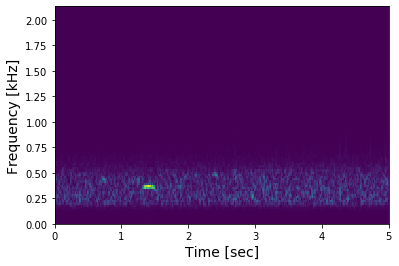

In [14]:
plt.pcolormesh(t[:],f[:100]/1e3,Syy[:100,:])
plt.ylabel('Frequency [kHz]', fontsize=14)
plt.xlabel('Time [sec]',fontsize=14)

Nimm das Muster vom ersten Fund

In [15]:
Template=Syy[:50,120:160]
Template.shape

(50, 40)

Text(0.5, 0, 'Time [sec]')

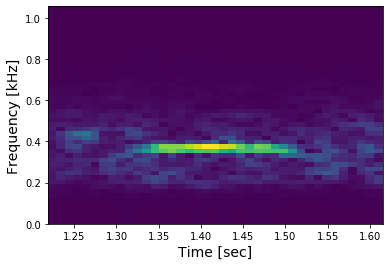

In [16]:
plt.pcolormesh(t[120:160],f[:50]/1e3,Template[:50,:])
plt.ylabel('Frequency [kHz]', fontsize=14)
plt.xlabel('Time [sec]',fontsize=14)

In [17]:
t_max=len(sig1)/rate
t_max

6995.616009070295

Template Matching auf Abschnitte mit 1000 Sekunden Zeit Intervalle

In [25]:
segment_length=1000
t_begin=0; t_end=t_begin+segment_length

In [26]:
list1=[] ## Create empty arrays for the time axis and the template matching result
result=np.array(list1)
time_axis=np.array(list1)
result

array([], dtype=float64)

In [27]:
while t_end<t_max:
    index_begin=t_begin*rate; index_end=t_end*rate;
    segment=sig1[index_begin:index_end]
    filtered=butter_bandpass_filter(segment, 200, 500, fs=rate, order=5)
    f, t, Sxx = signal.stft(filtered, fs,window=mywindow,noverlap=800,nfft=windowlength,nperseg=windowlength)
    Syy=abs(Sxx)
    segment_result=np.array(match_template(Syy[:50,:], Template))
    time_values=np.linspace(t_begin,t_end-delta_T,num=segment_result.shape[1])
    result=np.append(result,segment_result)
    time_axis=np.append(time_axis,time_values)
    t_begin+=segment_length
    t_end+=segment_length

## Do the above operations for the remainder part of the recording
index_begin=t_begin*rate; index_end=sig1.shape[0];
segment=sig1[index_begin:index_end]
filtered=butter_bandpass_filter(segment, 200, 500, fs=rate, order=5)
f, t, Sxx = signal.stft(filtered, fs,window=mywindow,noverlap=800,nfft=windowlength,nperseg=windowlength)
Syy=abs(Sxx)
segment_result=np.array(match_template(Syy[:50,:], Template))
time_values=np.linspace(t_begin,t_max-delta_T,num=segment_result.shape[1])
result=np.append(result,segment_result)
time_axis=np.append(time_axis,time_values)
    

In [28]:
time_axis.shape

(688368,)

In [29]:
result.shape

(688368,)

Template Matching Results

Text(0, 0.5, 'Template Match Value')

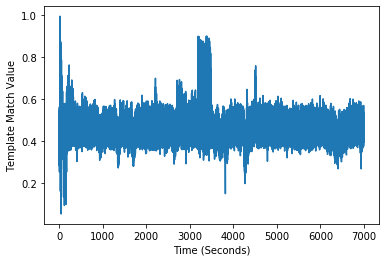

In [34]:
plt.plot(time_axis,result)
plt.xlabel('Time (Seconds)')
plt.ylabel('Template Match Value')

Die Ergebnisse gezeigt in kurzer Zeitinterval

Text(0, 0.5, 'Template Match Value')

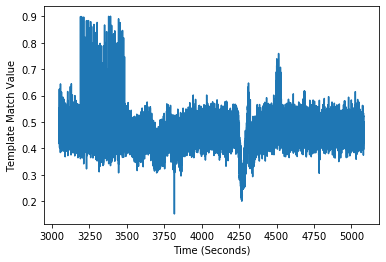

In [37]:
plt.plot(time_axis[300000:500000],result[300000:500000])
plt.xlabel('Time (Seconds)')
plt.ylabel('Template Match Value')

Find the positions of the maximas <br> which are above a THRESHOLD

In [187]:
peaks, _ = signal.find_peaks(result, height=0.70)

In [188]:
peaks.shape # Gesammte Zahl der Funde

(58,)

Positionen der Funde in Bezug auf die Zeit mit dem Template Matching

In [189]:
time_axis[peaks]

array([  13.22,   20.74,   32.08,   40.99,   49.1 ,   49.14,   57.57,
        194.99,  226.63, 2209.79, 3190.5 , 3197.53, 3204.7 , 3211.81,
       3218.37, 3230.45, 3237.36, 3243.65, 3251.67, 3258.21, 3264.67,
       3273.85, 3280.11, 3287.51, 3301.72, 3308.64, 3315.24, 3321.3 ,
       3328.08, 3334.66, 3343.63, 3351.16, 3358.6 , 3364.8 , 3378.42,
       3390.63, 3398.27, 3404.81, 3404.85, 3411.59, 3419.35, 3427.13,
       3435.5 , 3444.67, 3453.98, 3464.09, 3470.96, 3478.04, 3484.32,
       4500.65, 4501.03, 4501.06, 4501.1 , 4513.3 , 4513.85, 4513.93,
       4525.46, 4525.49])

Die Annotationen von Tim

In [122]:
Tim_finds = pd.read_csv('Tim-Uhu.csv',header=None).values[:,0:2]
print(Tim_finds)

[[3190.4553809999998 3190.838912]
 [3197.454832 3197.910276]
 [3204.693991 3205.029581]
 [3211.717413 3212.124915]
 [3218.309362 3218.740835]
 [3230.390607 3230.750167]
 [3237.294175 3237.701677]
 [3243.5025920000003 3244.101861]
 [3251.580726 3251.940287]
 [3258.100763 3258.580178]
 [3264.572859 3264.95639]
 [3273.777616 3274.137177]
 [3280.010005 3280.441478]
 [3287.416958 3287.776519]
 [3293.7692 3294.1767019999998]
 [3301.631597 3302.087041]
 [3308.583107 3308.870756]
 [3315.127115 3315.558588]
 [3321.191708 3321.623181]
 [3327.903511 3328.5267489999997]
 [3334.5194300000003 3335.094728]
 [3343.5324219999998 3343.915954]
 [3351.0112879999997 3351.634527]
 [3358.442212 3358.921627]
 [3364.5307759999996 3365.154015]
 [3378.194089 3378.769386]
 [3384.52236 3385.0976570000003]
 [3390.4191579999997 3390.9944549999996]
 [3397.993907 3398.665087]
 [3404.561885 3405.233065]
 [3411.3695700000003 3411.9928090000003]
 [3418.9443189999997 3419.759324]
 [3426.8546579999997 3427.4778969999998]
 

Die Funde mit CNN-Algorithmus von Mario

In [88]:
CNN_finds = np.loadtxt('VP2_20170330_c1_Bubo_bubo_TH4.txt', usecols=range(3))
CNN_finds.shape 

(84, 3)

Positionen der Funde im CNN Algorithmus

In [193]:
np.set_printoptions(precision=2,suppress=True)
print(CNN_finds[CNN_finds[:,2]>3.0])

[[  12.    17.     5.3]
 [  28.    33.     5.9]
 [  84.    89.     4.2]
 [3084.  3089.     5.1]
 [3088.  3093.     4.1]
 [3100.  3105.     4.1]
 [3188.  3193.     5.6]
 [3196.  3201.     6.7]
 [3200.  3205.     4.3]
 [3204.  3209.     7.4]
 [3208.  3213.     8.3]
 [3216.  3221.     5.5]
 [3228.  3233.     6.2]
 [3236.  3241.     5.7]
 [3240.  3245.     4.3]
 [3248.  3253.     6.8]
 [3260.  3265.     4.3]
 [3264.  3269.     8.1]
 [3276.  3281.     7.6]
 [3284.  3289.     4.1]
 [3300.  3305.     9.6]
 [3308.  3313.     5.5]
 [3312.  3317.     5.1]
 [3320.  3325.     7.4]
 [3328.  3333.     4.2]
 [3332.  3337.     4.2]
 [3348.  3353.    12.3]
 [3352.  3357.     6.3]
 [3356.  3361.     6.2]
 [3360.  3365.     6.8]
 [3364.  3369.    10.8]
 [3376.  3381.     7.2]
 [3388.  3393.     9.7]
 [3396.  3401.     5.6]
 [3416.  3421.     4.3]
 [3440.  3445.     5.8]
 [3444.  3449.     6.9]
 [3452.  3457.     6.3]
 [3460.  3465.     8.6]
 [3464.  3469.     4.2]
 [3468.  3473.    10. ]
 [3476.  3481.  